# 3. Autoencoders (AE) en MNIST

**Importación de módulos necesarios**

In [36]:
from keras.datasets import mnist
import numpy as np
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

**3.0 Creación de conjuntos de datos a utilizar**

En primer lugar, se crean los conjuntos de datos a ser utilizados en la resolución del problema. Para ello, el dataset completo de imágenes es obtenido desde el repositorio de *keras*. Posteriormente, las matrices que contienen las imágenes, *x_train* y *x_test*, son escaladas en base a la intensidad máxima de píxel y luego reorganizadas como un vector cada una.

Además, se crea el conjunto de validación que será usado más adelante, extrayendo para ello los últimos 5.000 registros del conjunto de entrenamiento.

In [37]:
# Se cargan conjutos de entrenamiento y de prueba
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Se normalizan conjuntos de datos en base a intensidad máxima de pixel
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Se transforman las imágenes de ambos conjuntos a vectores
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Se define conjunto de validación y se reestructura conjunto de entrenamiento
x_val = x_train[:5000, :]
x_train = x_train[5000:, :]
y_val = y_train[:5000]
y_train = y_train[5000:]

# 3.1 Reducción de dimensionalidad

En esta sección, se hará uso de diversos AE's como reductores de dimensionalidad, esperando mejorar el rendimiento de modelos convolucionales, los cuales recibirán como inputs las imágenes "reducidas" y serán entrenados para construir un clasificador de dígitos. 

**3.1.1 AE con una capa escondida**

Se comienza construyendo un AE simple, compuesto únicamente por una capa oculta (enconder) y una capa de salida (decoder). En principio, el encoder utilizará la función de activación sigmoide, para luego experimentar con ReLU, al igual que el decoder. Se usará *adam* como método de entrenamiento, dado a que permite que la tasa de aprendizaje se adapte a lo largo de este proceso, evitando que decrezca de forma muy rápida (como ocurre con adagrad). Además, se usará *binary crossentropy* como función de pérdida, dado a que el valor de cada atributo en cada uno de los inputs se encuentra en el intervalo [0, 1].

Para la implementación del AE, se construye la función *simple_AE*, que recibe como parámetro el nivel de compresión deseado y la función de activación del encoder. Como salida, se generan archivos que registran el porcentaje de compresión obtenido y el error de reconstrucción de cada configuración.

El enconder estará integrado por d' neuronas, con d' en {2, 8, 32, 64}. Esto quiere decir que el input original, de 784 dimensiones, será comprimido en un vector de d' dimensiones.

El decoder en cambio, estára compuesto, naturalmente, por 784 neuronas, pues se busca restaurar la estructura inicial del input recibido.

In [11]:
# Implementación de función simple_AE; d_ : compresión deseada; act_func: función de activación encoder
def simple_AE(d_, act_functions):
    # Se determina el tipo de input a ser recibido por el AE
    input_img = Input(shape=(784,))
    # "encoded" es la versión codificada del input
    encoded = Dense(d_, activation=act_functions[0])(input_img)
    # "decoded" es la reconstrucción del input codificado
    decoded = Dense(784, activation=act_functions[1])(encoded)
    # Se genera AE a partir de capas anteriores, el cual mapea un input hacia su reconstrucción
    autoencoder = Model(input=input_img, output=decoded)
    # Se definen método de entrenamiento y función de pérdida
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    # Se entrena AE
    history = autoencoder.fit(x_train, x_train,
              epochs=50,
              batch_size=256,
              shuffle=True,
              verbose=0,
              validation_data=(x_val, x_val))
    # Se guardan porcentaje de compresión y error de reconstrucción en un archivo
    autoencoder.save('basic_autoenconder_784x' + str(d_) + act_functions[0] + '_' + act_functions[1] + '.h5')

Así, se procede a generar AE's para d' dimensiones y utilizando la función ReLU y/o sigmoide en el enconder y/o el decoder.

In [12]:
# Valores posibles para la dimensión del input comprimido
dimensions = [2, 8, 32, 64]
# Funciones de activación posibles
activations = [('sigmoid', 'sigmoid'), ('relu', 'sigmoid'), ('sigmoid', 'relu')]

In [13]:
warnings.filterwarnings('ignore')

# Se generan todos los AE's posibles
for dimension in dimensions:
    for activation in activations:
        simple_AE(dimension, activation)

Generados los archivos, se procede a leerlos para determinar el rendimiento de cada una de las configuraciones. 

In [14]:
for activation in activations:
    print('Encoder: ' + activation[0] + ' | ' + 'Decoder: ' + activation[1])
    for dimension in dimensions:
        autoencoder = load_model('basic_autoenconder_784x' + str(dimension) + activation[0] + '_' + activation[1] + '.h5')
        # Se determina nivel de compresión
        compression = 784. / float(dimension)
        
        # Se determina error de reconstrucción
        x_pred = autoencoder.predict(x_test)
        m,n = x_test.shape
        aux = ((x_test - x_pred) ** 2).sum(axis=1) / n
        reconstruction_error = aux.sum() / m
        
        print('Compresion: ' + str(compression) + ' %' + ' | ' + 'Error de reconstruccion: ' + str(reconstruction_error))
    print('\n')

Encoder: sigmoid | Decoder: sigmoid
Compresion: 392.0 % | Error de reconstruccion: 0.0737222473145
Compresion: 98.0 % | Error de reconstruccion: 0.0677533203125
Compresion: 24.5 % | Error de reconstruccion: 0.067586517334
Compresion: 12.25 % | Error de reconstruccion: 0.0497077484131


Encoder: relu | Decoder: sigmoid
Compresion: 392.0 % | Error de reconstruccion: 0.0611295227051
Compresion: 98.0 % | Error de reconstruccion: 0.0397953369141
Compresion: 24.5 % | Error de reconstruccion: 0.018370274353
Compresion: 12.25 % | Error de reconstruccion: 0.0110378128052


Encoder: sigmoid | Decoder: relu
Compresion: 392.0 % | Error de reconstruccion: 0.0860361450195
Compresion: 98.0 % | Error de reconstruccion: 0.0692317749023
Compresion: 24.5 % | Error de reconstruccion: 0.0543657836914
Compresion: 12.25 % | Error de reconstruccion: 0.0467615783691




En consecuencia, se observa que no es una buena práctica utilizar la función de activación relu en el decoder, pues independiente de la compresión utilizada, el error de reconstrucción es superior o igual al 5%.
Por otro lado, los errores más bajos se consiguen al usar relu en el encoder y sigmoide en el decoder, para toda compresión posible.
Es importante notar que si la compresión es demasiado alta (es decir, si el input codificado posee una baja dimensionalidad), el error aumenta, como ocurre para d' = 2, dimensión para la que se obtienen los errores más altos, independiente de las funciones de activación utilizadas.

**3.1.2 Comparando reconstrucciones de imágenes**

Se desea comparar la "calidad" de reconstrucción de los autoencoders implementados en la sección anterior sobre algunas imágenes del conjunto de pruebas. Considerando que al utilizar la función de activación ReLU en el encoder y sigmoide en en el decoder se obtienen los errores de reconstrucción más bajos, se recuperarán los cuatro modelos que hacen uso de esta configuración.

In [8]:
# Se recuperan autoencoders de encoder ReLU y decoder sigmoide, para cada d' posible
autoencoder_784x2 = load_model('basic_autoenconder_784x2relu_sigmoid.h5')
autoencoder_784x8 = load_model('basic_autoenconder_784x8relu_sigmoid.h5')
autoencoder_784x32 = load_model('basic_autoenconder_784x32relu_sigmoid.h5')
autoencoder_784x64 = load_model('basic_autoenconder_784x64relu_sigmoid.h5')

autoencoders = {}
autoencoders['autoencoder_784x2'] = autoencoder_784x2
autoencoders['autoencoder_784x8'] = autoencoder_784x8
autoencoders['autoencoder_784x32'] = autoencoder_784x32
autoencoders['autoencoder_784x64'] = autoencoder_784x64

Luego, se continúa con la implementación de forma separada de un encoder y un decoder para cada d' posible. Para ello, se crean las funciones *make_encoder* y *make_autoencoder*, que reciben como parámetro d' y la función de activación deseada, en cada caso.

In [9]:
# Función para creación de encoder
def make_encoder(d_, act_function):
    input_img = Input(shape=(784,))
    encoded = Dense(d_, activation=act_function)(input_img)
    # Se define encoder, el cual mapea un input hacia su versión codificada
    encoder = Model(input=input_img, outputs=encoded)
    return encoder

# Función para creación de encoder
def make_decoder(d_, act_function, autoencoder):
    # encoded_input: Capa que permite la entrada de un input codificado en 32 dimensiones
    encoded_input = Input(shape=(d_,))
    # Se recupera última capa de autoencoder
    decoder_layer = autoencoder.layers[-1]
    # Se define decoder, el cual mapea un input comprimido hacia su versión "original"
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    return decoder

Así, para cada d' posible, se estudian diez imágenes del conjunto de pruebas. Por cada una, se comparan su versión original y su reconstrucción. El siguiente código permite que, para cada d', se impriman dos filas de imágenes. La primera de ellas muestra las imágenes originales, mientras que la segunda muestra muestra las reconstrucciones llevadas a cabo por el autoencoder respectivo.

Imagenes para d' = 2


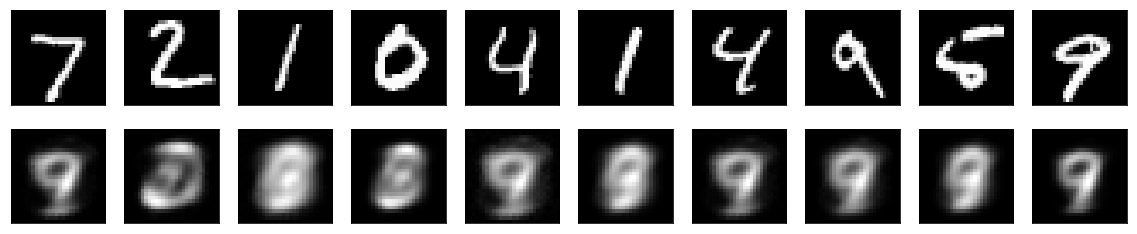

Imagenes para d' = 8


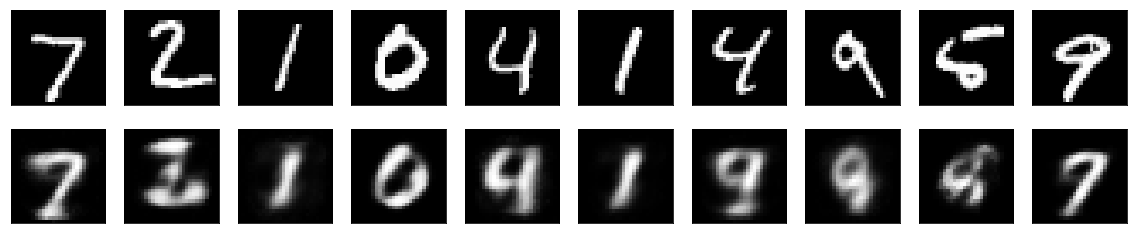

Imagenes para d' = 32


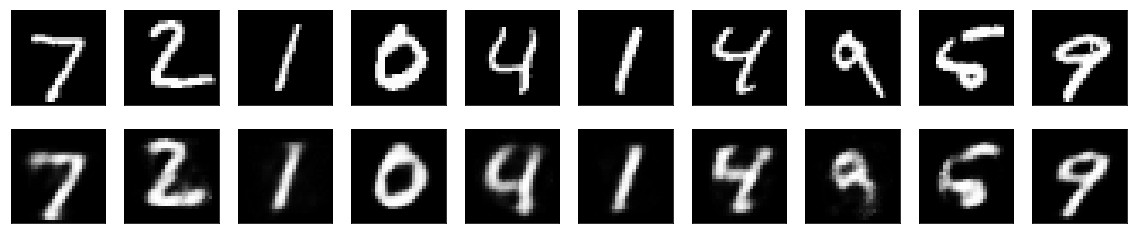

Imagenes para d' = 64


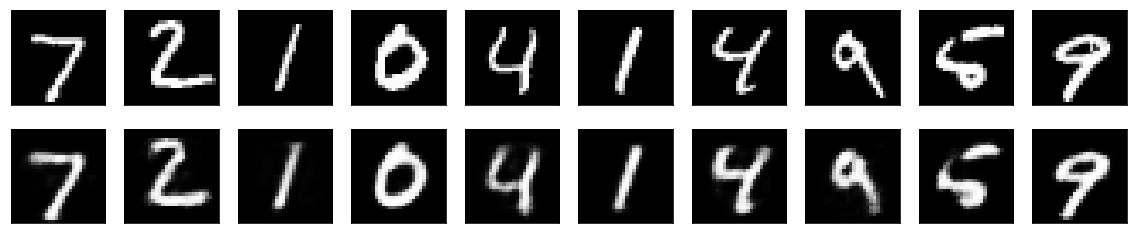

In [22]:
warnings.filterwarnings('ignore')

# Funciones de activación de encoder y decoder
encoder_act_function = 'relu'
decoder_act_function = 'sigmoid'
n = 10 # Cantidad de imágenes a estudiar por cada d'

for dimension in dimensions:
    
    print "Imagenes para d' = " + str(dimension)
    
    autoencoder = autoencoders['autoencoder_784x' + str(dimension)]
    decoded_test = autoencoder.predict(x_test)
    
    plt.figure(figsize=(20, 4))
    
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

Las imágenes hablan por si solas: A medida que la cantidad de dimensiones de la nueva representación aumenta, la calidad de las reconstrucciones también lo hace. Esto es consistente con los errores de reconstrucción calculados previamente, ya que estos disminuyeron al aumentar la cantidad de dimensiones de la nueva representación.

**3.1.3 Clasificación de dígitos por medio de kNN**

Con el fin de determinar la calidad de la compresión realizada por un autoencoder, se implementará un clasificador kNN para posteriormente evaluarlo sobre el conjunto de pruebas. En primer lugar, dicho clasificador es entrenado a partir de los ejemplos originales contenidos en el conjunto de entrenamiento (sin compresión) para efectos comparativos. Para el modelo, se utilizará k = 10.

In [4]:
# Se crea clasificador kNN, con k = 10
clf_original = KNeighborsClassifier(10)
# Se entrena clasificador a partir de ejemplos sin compresión
clf_original.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

A continuación, se determina el error que se obtiene al evaluar el modelo sobre el conjunto de pruebas, junto con el tiempo medio necesario para la clase de ejemplo perteneciente a este set de datos.

In [7]:
t_i = time.time()
print 'Error de clasificacion sobre conjunto de pruebas luego de entrenar sobre ejemplos sin compresion: ', \
    (1 - clf_original.score(x_test, y_test)) * 100, ' %'
t_f = time.time()
print 'Tiempo medio de prediccion: ', (t_f - t_i) / len(x_test), '[s]'

Error de clasificacion sobre conjunto de pruebas luego de entrenar sobre ejemplos sin compresion:  7.49  %
Tiempo medio de prediccion:  0.0237389283895 [s]


Se observa entonces que el error de clasificación es de un 7,49%, mientras que el tiempo medio de predicción fue de 0,024 [s] por ejemplo, durando 240 [s] el proceso completo.

Con estas métricas en mente, se procede a implementar otro clasificador kNN, nuevamente con k = 10, pero entrenándolo a partir de los ejemplos comprimidos. Se utilizará una compresión d' = 2, 4, 8, 16, 32, y funciones de activación ReLU y sigmoide para el encoder y el decoder, respectivamente, dados los buenos resultados obtenidos para este modelo en las secciones previas.

Se implementará, además, un enconder por separado, para cada d' posible, pues en este punto no se requiere utilizar un decoder.

In [8]:
warnings.filterwarnings('ignore')
input_img = Input(shape=(784, ))

for dimension in [2, 4, 8, 16, 32, 64]:
    
    print "d' = ", dimension
    
    # Se implementa encoder por separado
    encoded = Dense(dimension, activation='relu')(input_img)
    encoder = Model(input_img, output=encoded)
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    
    # Se crea clasificador kNN, con k = 10
    clf_compressed = KNeighborsClassifier(10)
    # Se entrena clasificador a partir de ejemplos comprimidos
    clf_compressed.fit(encoded_train, y_train)
    
    t_i = time.time()
    print "Error de clasificacion sobre conjunto de pruebas: ", \
    (1 - clf_compressed.score(encoded_test, y_test)) * 100, ' %'
    t_f = time.time()
    print 'Tiempo medio de prediccion: ', (t_f - t_i) / len(x_test), '[s]\n'

d' =  2
Error de clasificacion sobre conjunto de pruebas:  82.26  %
Tiempo medio de prediccion:  1.09549045563e-05 [s]

d' =  4
Error de clasificacion sobre conjunto de pruebas:  72.67  %
Tiempo medio de prediccion:  9.47258472443e-06 [s]

d' =  8
Error de clasificacion sobre conjunto de pruebas:  55.56  %
Tiempo medio de prediccion:  3.13601016998e-05 [s]

d' =  16
Error de clasificacion sobre conjunto de pruebas:  43.18  %
Tiempo medio de prediccion:  0.00010530591011 [s]

d' =  32
Error de clasificacion sobre conjunto de pruebas:  25.25  %
Tiempo medio de prediccion:  0.000315763020515 [s]

d' =  64
Error de clasificacion sobre conjunto de pruebas:  16.13  %
Tiempo medio de prediccion:  0.000719285702705 [s]



Se observa como, al aumentar la compresión, el error de clasificación disminuye, al igual que el tiempo promedio de clasificación.

Desafortunadamente, el error más bajo obtenido al comprimir los datos (para d' = 64), es de un 16,13%, ósea, es superior en un 8,64% al error obtenido sobre los datos sin compresión. Sin embargo, el tiempo promedio de clasificación disminuye notablemente a 0,0007 [s] por ejemplo, lo que en suma entrega un tiempo total de predicción de 7 [s].

Ante esta situación, se puede decir que efectivamente la comprensión permitió la predicción de las clases de cada ejemplo de forma mucho más eficiente en términos de tiempo, pero resultan ser compresiones quizás demasiado altas como para que el modelo sea capaz de generar buenas predicciones a partir de los ejemplos modificados.

**3.1.4 Comparación de efectos de reducción de dimensionalidad con PCA**

En esta sección, los ejemplos serán comprimidos por medio de la técnica de reducción de dimensionalidad PCA. Luego, se realizarán predicciones y los resultados serán comparados con aquellos obtenidos al reducir la dimensionalidad de los datos por medio de autoencoders. Como métricas de comparación, se considerarán el error de reducción y el error de clasificación por medio de kNN.

In [14]:
warnings.filterwarnings('ignore')

for dimension in [2, 4, 8, 16, 32, 64]:
    
    print "d' = ", dimension
    
    # Se define nivel de compresión, vía PCA
    pca = PCA(n_components=dimension)
    
    # Se realiza reducción de dimensionalidad para conjuntos de entrenamiento y de prueba
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    
    # Se determina error de reconstrucción
    #Primero, se estiman las componentes
    U, S, VT = np.linalg.svd(x_test - x_test.mean(0))
    # Después, se calculan las cargas
    pca_train_2 = (x_test - pca.mean_).dot(pca.components_.T)
    # Luego, se obtienen las proyecciones sobre las componentes principales
    x_projected = pca.inverse_transform(pca_test)
    x_projected_2 = pca_test.dot(pca.components_) +pca.mean_
    # Finalmente, se calcula error de reconstrucción
    reconstruction_error = ((x_test - x_projected) ** 2).mean()
    
    # Se crea clasificador kNN, con k = 10
    clf_pca = KNeighborsClassifier(10)
    # Se entrena clasificador a partir de ejemplos comprimidos
    clf_pca.fit(pca_train, y_train)
    
    print "Error de reconstruccion: ", reconstruction_error
    print "Error de clasificacion sobre conjunto de pruebas: ", \
    (1 - clf_pca.score(pca_test, y_test)) * 100, ' %\n'

d' =  2
Error de reconstruccion:  0.0555464589765
Error de clasificacion sobre conjunto de pruebas:  56.1  %

d' =  4
Error de reconstruccion:  0.0478027744412
Error de clasificacion sobre conjunto de pruebas:  34.5  %

d' =  8
Error de reconstruccion:  0.0374364073754
Error de clasificacion sobre conjunto de pruebas:  12.39  %

d' =  16
Error de reconstruccion:  0.026818733527
Error de clasificacion sobre conjunto de pruebas:  6.67  %

d' =  32
Error de reconstruccion:  0.0168441006868
Error de clasificacion sobre conjunto de pruebas:  5.76  %

d' =  64
Error de reconstruccion:  0.00897680423945
Error de clasificacion sobre conjunto de pruebas:  6.23  %



En general, los errores de reconstrucción obtenidos son más bajos que los de los autoencoders, independiente del nivel de compresión empleado. Por otra parte, los errores de clasificación son considerablemente más bajos. Por ejemplo, para d' = 2, el error de clasificación obtenido a partir del uso de un autoencoder es de un 82,26%, mientras que con PCA el error es un 34,5%. Para ambos reductores de dimensionalidad, el error de clasificación más bajo es conseguido con d' = 64, pero para el autoencoder es de un 16,13%, mientras que para PCA es de un 6,23%.

**3.1.5 Implementación de *deep autoencoder* (deep AE)**

Se desea conocer el efecto que tiene agregar más capas ocultas al autoencoder definido en la sección 3.1.1 sobre el error de reconstrucción y el error de clasificación. Para determinar este último, se continuará trabajando con kNN (k = 10). Al igual que en la sección 3.1.3, se implementará un encoder de forma separada para determinar el error de reconstrucción, dado a que no se requiere del decoder para este calculo. Para esto se construye la función *make_deep_encoder* que, a partir de una lista con las dimensionalidades deseadas para cada capa, genera el encoder requerido.

El encoder estará compuesto por tres capas ocultas, las que se encargarán de disminuir paulatinamente las dimensiones del input recibido: Primero a 500 dimensiones, luego a 250 dimensiones y finalmente a d' atributos, con d' = 2, 4, 8, 16, 32. Dados los buenos resultados de las secciones anteriores, se utilizará ReLU como función de activación en estas capas.

El decoder también estará integrado por tres capas ocultas, las que se encargarán de reconstruir el input recibido, o en otras palabras, el output producido por el encoder.

Para efectuar el entrenamiento del autoencoder, se utilizará Adam como método de optimización y binary cross entropy como función de pérdida.

Se implementa, entonces, la función *deep_autoencoder*, la que se encargará de definir un autoencoder con las características señaladas previamente. Recibe como parámetro la compresión d' final deseada y una lista con las dimensionalidades de salida por cada capa.

In [38]:
def make_deep_autoencoder(layers_output_dimensions):
    # Se almacenan capas de encoder
    encoder_layers = []
    # Tipo de input a ser recibido por el autoencoder
    input_img = Input(shape=(784,))
    encoder_layers.append(input_img)
    
    # Se definen capas ocultas de encoder
    for output_dimension in layers_output_dimensions:
        encoded_layer = Dense(output_dimension, activation='relu')(encoder_layers[-1])
        encoder_layers.append(encoded_layer)
    
    # Se define encoder
    encoder = Model(input=encoder_layers[0], output=encoder_layers[1])
    
    return encoder

In [29]:
# deep_autoencoder implementa un autoencoder de profundidad L que comprime los inputs a d' dimensiones y
# luego los reconstruye
def deep_autoencoder(d_, layers_output_dimensions):
    
    # Se almacenan capas de autoencoder
    autoencoder_layers = []  
    # Tipo de input a ser recibido por el autoencoder
    input_img = Input(shape=(784,))
    autoencoder_layers.append(input_img)
    
    # Se definen capas ocultas de encoder
    for output_dimension in layers_output_dimensions:
        encoded_layer = Dense(output_dimension, activation='relu')(autoencoder_layers[-1])
        autoencoder_layers.append(encoded_layer)
    
    # Se definen capas ocultas de decoder
    for output_dimension in reversed(layers_output_dimensions[:-1]):
        decoded_layer = Dense(output_dimension, activation='relu')(autoencoder_layers[-1])
        autoencoder_layers.append(decoded_layer)
        
    # Se agrega capa que reconstruye input original    
    output_img = Dense(784, activation='sigmoid')(autoencoder_layers[-1])
    autoencoder_layers.append(output_img)
        
    # Se define autoencoder
    autoencoder = Model(autoencoder_layers[0], output=autoencoder_layers[-1])
    
    # Se definen parámetros de entrenamiento
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Se entrena autoencoder
    history = autoencoder.fit(x_train, x_train,
              epochs=50,
              batch_size=25,
              shuffle=True,
              verbose=0,
              validation_data=(x_val, x_val))

    # Se guarda modelo entrenado en un archivo
    autoencoder.save('deep_AE_784xL=' + str(len(layers_output_dimensions)) + 'xd_=' + str(d_) + '.h5')

Así, se procede a entrenar un autoencoder para cada dimensionalidad d' y profundidad L posible.

In [31]:
warnings.filterwarnings('ignore')
dimensions = [2, 4, 8, 16, 32]
depths = [[250], [500, 250], [750, 500, 250]]

# Se generan todos los AE's posibles
for dimension in dimensions:
    for depth in depths:
        deep_autoencoder(dimension, depth + [dimension])

Ya generados los archivos, se procede a determinar el error de reconstrucción y el error de clasificación para cada caso.

In [43]:
warnings.filterwarnings('ignore')
input_img = Input(shape=(784, ))

for depth in [[250], [500, 250], [750, 500, 250]]:
    print 'L: ' + str(len(depth) + 1)
    for dimension in dimensions:
        
        depth.append(dimension)
        autoencoder = load_model('deep_AE_784xL=' + str(len(depth)) + 'xd_=' + str(dimension) + '.h5')
        
        # Se determina error de reconstrucción
        x_pred = autoencoder.predict(x_test)
        n_test_images, n_test_features = x_test.shape
        aux = ((x_test - x_pred) ** 2).sum(axis=1) / n_test_features
        reconstruction_error = aux.sum() / n_test_images
        
        # Se determina error de clasificación con kNN, para k = 10
        # Primero, se implementa enconder por separado
        encoder = make_deep_autoencoder(depth)
        encoded_train = encoder.predict(x_train)
        encoded_test = encoder.predict(x_test)
        
        # Luego, se implementa el clasificador
        clf_deep = KNeighborsClassifier(10)
        # Se entrena clasificador a partir de ejemplos comprimidos
        clf_deep.fit(encoded_train, y_train)
        
        # Se imprimen resultados por pantalla
        print "d': " + str(dimension) + ' | ' + 'Error de reconstruccion: ' \
            + str(reconstruction_error) + ' | ' + 'Error de clasificacion sobre conjunto de pruebas: ' \
            + str((1 - clf_deep.score(encoded_test, y_test)) * 100) + ' %'
            
        del depth[-1]
        
    print '\n'

L: 2
d': 2 | Error de reconstruccion: 0.0466095092773 | Error de clasificacion sobre conjunto de pruebas: 9.68 %
d': 4 | Error de reconstruccion: 0.0341434295654 | Error de clasificacion sobre conjunto de pruebas: 10.25 %
d': 8 | Error de reconstruccion: 0.0241543609619 | Error de clasificacion sobre conjunto de pruebas: 9.67 %
d': 16 | Error de reconstruccion: 0.0146761154175 | Error de clasificacion sobre conjunto de pruebas: 9.33 %
d': 32 | Error de reconstruccion: 0.00897728881836 | Error de clasificacion sobre conjunto de pruebas: 9.5 %


L: 3
d': 2 | Error de reconstruccion: 0.0418215362549 | Error de clasificacion sobre conjunto de pruebas: 8.57 %
d': 4 | Error de reconstruccion: 0.0317069976807 | Error de clasificacion sobre conjunto de pruebas: 8.77 %
d': 8 | Error de reconstruccion: 0.0232519424438 | Error de clasificacion sobre conjunto de pruebas: 8.57 %
d': 16 | Error de reconstruccion: 0.0157637374878 | Error de clasificacion sobre conjunto de pruebas: 8.69 %
d': 32 | Err

Los resultados muestran que el error de reconstrucción no se ve mayormente afectado en comparación a los casos en que se implementó un autoencoder simple, por lo que puede decirse que si se desea disminuir el error de reconstrucción no tiene tiene sentido aumentar la profundidad del autoencoder.

Se ve además que, para cada compresión posible, el error de clasificación disminuye notablemente con la profundidad, presentándose los errores más bajos para L = 4. De hecho, ya con L = 2 el error es menor para cada d' posible respecto a los autoencoders antes usados. Naturalmente, el tiempo asociado a la reducción de dimensionalidad y al entrenamiento aumenta, pero la ganancia que proporcionan estos modelos en términos del error de clasificación resulta ser más importante.

De esta forma, se tiene que la arquitectura que logra resolver, hasta ahora, de mejor forma el problema planteado, es un deep autoencoder con 4 capas ocultas, dimensionalidad de 16 atributos para los outputs comprimidos y utilizando función de activación reLU en las capas ocultas y sigmoide en la capa de salida. Esta configuración obtiene un error de reconstrucción 0,02 y error de clasificación sobre el conjunto de pruebas de 8,06%.

**3.1.6 Visualización de representaciones**

En la siguiente sección, se visualizan las representaciones encontradas en la sección anterior para cada profundidad L = 2, 3, 4. Para que las visualizaciones sean compresibles, cada uno de estos casos se mostrará sólo para la compresión d' = 2. En cada caso, se mostrarán las representaciones encontradas para las primeras 500 imágenes del conjunto de entrenamiento.

Cada visualización muestra el valor que tiene tanto la primera como la segunda componente del dato (imágen) escogido.

Para representar cada dígito, se utilizará la siguiente notación:

- 0: o
- 1: +
- 2: v
- 3: <
- 4: >
- 5: ^
- 6: s
- 7: p
- 8: *
- 9: x

Para realizar esta tarea, se implementa la función *visualize*, que recibe como parámetro el encoder con que se trabajó para realizar la compresión, la profundidad de este y la cantidad de datos a visualizar (por defecto, se muestran 500).

In [79]:
# Se define color para representar cada dígito
colors = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'orange', 8: 'darkgreen', 9: 'maroon'}
# Se define símbolo para representar dígito
markers = {0: 'o', 1: '+', 2: 'v', 3: '<', 4: '>', 5: '^', 6: 's', 7: 'p', 8: '*', 9: 'x'}

def visualize(encoder, L, nplot=500):
    model = TSNE(n_components=2, random_state=0)
    
    # Se genera visualización
    encoded_train = encoder.predict(x_train[:nplot])
    encoded_train = model.fit_transform(encoded_train)
    
    # Se construye gráfico
    plt.figure(figsize=(10, 10))
    plt.xlabel('Primera componente')
    plt.ylabel('Segunda componente')
    plt.title("Visualizacion de representacion de dAE para d' = 2, L = " + str(L))
    for idx in xrange(0, nplot):
        label = y_train[idx]
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1], color=colors[label], marker=markers[label],
                        markersize=6)
    plt.show()

Definida la función de visualización, se generan las representaciones en 2 dimensiones para cada profundidad posible.

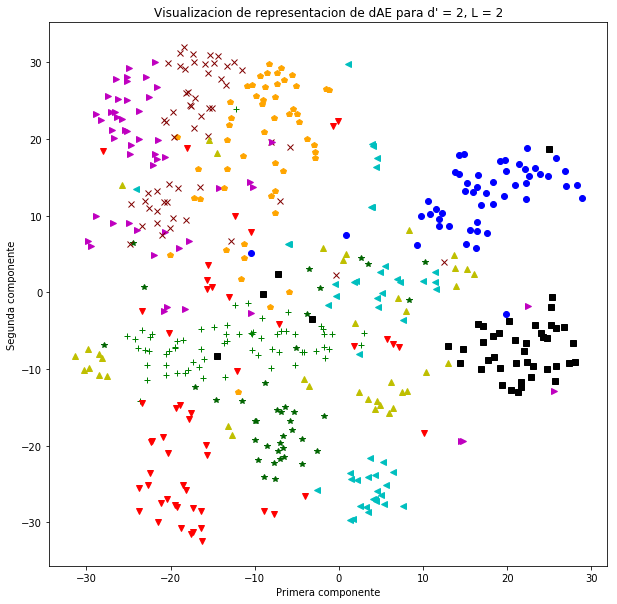

In [80]:
# Se visualiza representación de datos con d' = 2, L = 2
depth = [250, 2]
encoder = make_deep_autoencoder(depth)
visualize(encoder, len(depth))

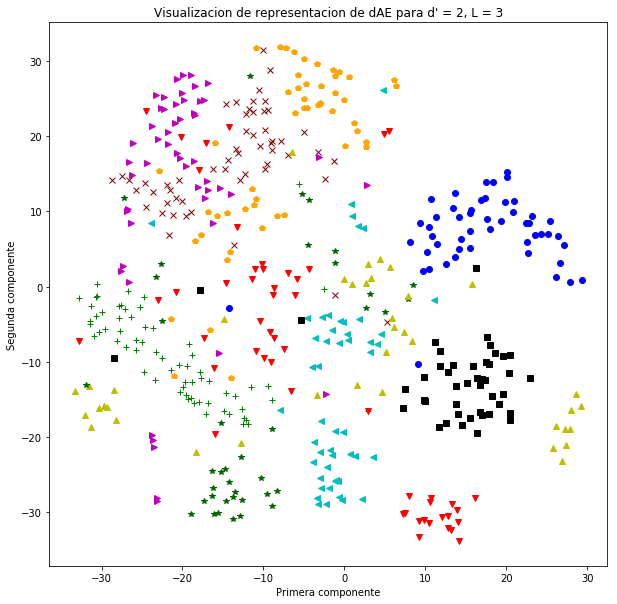

In [73]:
# Se visualiza representación de datos con d' = 2, L = 3
depth = [500, 250, 2]
encoder = make_deep_autoencoder(depth)
visualize(encoder, len(depth))

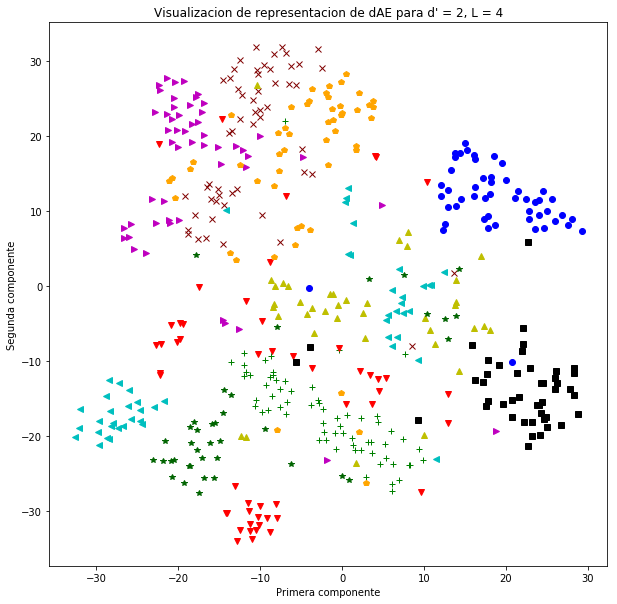

In [74]:
# Se visualiza representación de datos con d' = 2, L = 4
depth = [750, 500, 250, 2]
encoder = make_deep_autoencoder(depth)
visualize(encoder, len(depth))

Para efectos comparativos, también se muestra la representación generada por PCA para d' = 2.

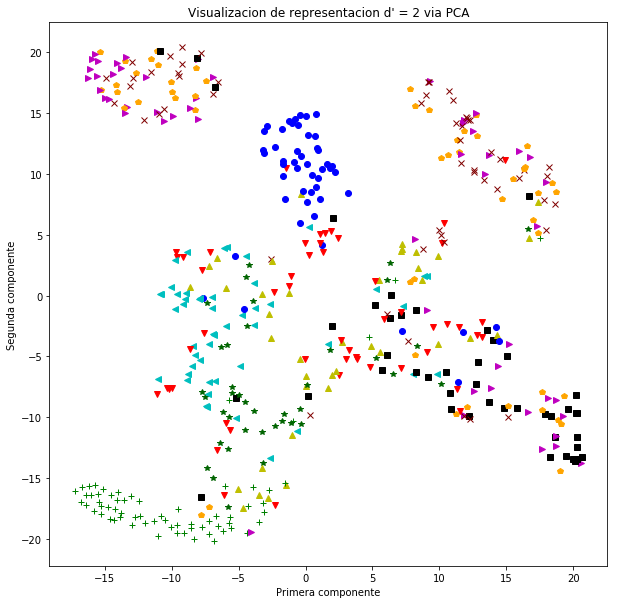

In [81]:
nplot = 500

# Se realiza reducción de dimensionalidad vía PCA
pca = PCA(n_components=2)
x_train_compressed = pca.fit(x_train[:nplot]).transform(x_train[:nplot])

# Se grafica representación
model = TSNE(n_components=2, random_state=0)
encoded_train = x_train_compressed
encoded_train = model.fit_transform(x_train_compressed)
plt.figure(figsize=(10, 10))
plt.xlabel('Primera componente')
plt.ylabel('Segunda componente')
plt.title("Visualizacion de representacion d' = 2 via PCA")
for idx in xrange(0, nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1], color=colors[label], marker=markers[label],
                    markersize=6)
plt.show()

Los gráficos muestran que los autoencoders tienen el efecto de hacer que aquellos puntos asociados a los mismos dígitos presenten valores similares en cada una de sus componentes, logrando así que se formen zonas de agrupamientos de dígitos en cada gráfico.

Sin embargo, el comportamiento antes descrito no se presenta en PCA. Los puntos asociados a dígitos diferentes están frecuentemente mezclados, salvo por los dígitos 0 y 1 que presentan un mayor agrupamiento.

** 3.1.7 Construcción de autoencoder a partir de capas convolucionales **

Para finalizar el estudio de reducción de dimensionalidad por medio de autoencoders, se implementará un autoencoder convolucional para la realización de este proceso. Notar que como las redes convolucionales reciben inputs de dimensiones (número de filas de la imágen, número de columnas de la imágen, número de canales de la imágen) es necesario reescalar cada uno de los conjuntos de datos.

In [3]:
# Se redimensionan conjuntos de datos
x_train_ = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val_ = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test_ = np.reshape(x_test, (len(x_test), 28, 28, 1))

Ya redimensionados los conjuntos de datos, se implementa el autoencoder convolucional.

El encoder estará compuesto por:

- Una capa convolucional de 16 filtros, cada uno de tamaño 3 x 3, con función de activación ReLU
- Una capa max pooling con factor de reducción 7 en cada dimensión
- Una capa convolucional de 8 filtros, cada uno de tamaño 3 x 3, con función de activación ReLU
- Una capa de max pooling con factor de reducción de 2 en cada dimensión

El decoder estará integrado por:

- Una capa convolucional de 8 filtros, cada uno de tamaño 3 x 3, con función de activación ReLU
- Una capa up sampling con factor de amplificación 2 en cada dimensión
- Una capa convolucional de 16 filtros, cada uno de tamaño 3 x 3, con función de activación ReLU
- Una capa up sampling con factor de amplificación 7 en cada dimensión

In [4]:
# Input a ser recibido por el autoencoder
input_img = Input(shape=(28, 28, 1))

# Se define encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((7, 7), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
encoded = MaxPooling2D((2, 2))(x)

# Se define decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((7, 7))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Se define autoencoder
autoencoder = Model(input_img, decoded)

# Se definen parámetros de entrenamiento
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

A continuación, se muestra como varian las dimensiones de un input determinado que es propagado a través del autoencoder. Notar que el output comprimido que genera el encoder posee dimensiones (2, 2, 8), esto es, imágenes de 2 filas, 2 columnas y 8 canales. Es importante tener esto en cuenta, pues si cada una de imágenes es transformada a un vector, tal y como se llevó a cabo en las secciones anteriores, entonces dichas imágenes quedarán definidas por d' = 2 x 2 x 8 = 32 atributos. 

In [5]:
# Se muestran características de encoder generado
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 4, 4, 8)           0         
__________

Estando ya diseñado el autoencoder convolucional, se procede a entrenarlo.

In [6]:
# Se entrena autoencoder
autoencoder.fit(x_train_, x_train_,
                epochs=50,
                batch_size=128,
                shuffle=True,
                verbose=1,
                validation_data=(x_val_, x_val_))

# Se guarda autoencoder en archivo
autoencoder.save('convolutional_autoencoder.h5')

Train on 5000 samples, validate on 55000 samples
Epoch 1/50
5000/5000 [==============================] - 20s - loss: 0.5413 - acc: 0.7716 - val_loss: 0.3931 - val_acc: 0.8088
Epoch 2/50
5000/5000 [==============================] - 20s - loss: 0.3345 - acc: 0.8043 - val_loss: 0.3065 - val_acc: 0.8071
Epoch 3/50
5000/5000 [==============================] - 20s - loss: 0.2982 - acc: 0.8014 - val_loss: 0.2903 - val_acc: 0.7999
Epoch 4/50
5000/5000 [==============================] - 20s - loss: 0.2866 - acc: 0.7987 - val_loss: 0.2849 - val_acc: 0.7864
Epoch 5/50
5000/5000 [==============================] - 20s - loss: 0.2807 - acc: 0.7983 - val_loss: 0.2779 - val_acc: 0.7973
Epoch 6/50
5000/5000 [==============================] - 20s - loss: 0.2750 - acc: 0.7983 - val_loss: 0.2728 - val_acc: 0.8025
Epoch 7/50
5000/5000 [==============================] - 20s - loss: 0.2697 - acc: 0.7988 - val_loss: 0.2676 - val_acc: 0.7940
Epoch 8/50
5000/5000 [==============================] - 21s - loss: 0

De igual forma, se implementa el encoder por separado, para posteriormente determinar el error de clasificación.

In [7]:
# Se implementa encoder por separado
encoder = Model(inputs=input_img, outputs=encoded)
# Se guarda encoder en archivo
encoder.save('convolutional_encoder.h5')

Ya definidos el autoencoder y el encoder, se procede a determinar el error de reconstrucción.

In [ ]:
warnings.filterwarnings('ignore')

# Se cargan autoencoder y encoder a partir de archivos generados previamente
autoencoder = load_model('convolutional_autoencoder.h5')
encoder = load_model('convolutional_encoder.h5')

# Se determina Error de reconstrucción
x_pred = autoencoder.predict(x_test_)
reconstruction_error = ((x_test_ - x_pred) ** 2).mean()
print "Error de reconstruccion: " + str(reconstruction_error)

Se ve que ...

Dado que ...

Finalmente, se determina el error de clasificación.

In [38]:
# Error de clasificación

# Se comprimen conjuntos de entrenamiento, validación y prueba
encoded_train = encoder.predict(x_train_)
encoded_val = encoder.predict(x_val_)
encoded_test = encoder.predict(x_test_)

# Se "aplanan" datos de cada conjunto
encoded_train = encoded_train.reshape(len(encoded_train), np.prod(encoded_train.shape[1:]))
encoded_val = encoded_val.reshape(len(encoded_val), np.prod(encoded_val.shape[1:]))
encoded_test = encoded_test.reshape(len(encoded_test), np.prod(encoded_test.shape[1:]))

# Se implementa clasificador kNN con k = 10 
clf_conv = KNeighborsClassifier(10)
# Se entrena clasificador a partir de ejemplos comprimidos
clf_conv.fit(encoded_train, y_train)
# Se determina error de clasificación
print 'Error de clasificacion sobre conjunto de pruebas: ' + str((1 - clf_conv.score(encoded_test, y_test)) * 100) + ' %'

Error de clasificacion sobre conjunto de pruebas: 30.51 %


Así, se puede ver que ...